## Telco Churn 

## Goal:



## imports

In [1]:
import numpy as np
import warnings
import pandas as pd
import math
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import numpy as np
import wrangle
from scipy import stats
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
## updating the pandas viewing options
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
warnings.filterwarnings("ignore")

## Acquire

- Data acquired from SQL database
- It contained 7043 rows and 24 columns before cleaning
- Each row represents a telco customer
- Each column represents a catagory of data

## Prepare

- made dummy columns of the datatype object columns to get a numeric
for those columns

- checked for nulls in the data and converted the total_charges column
to 0 because those customers had zero tenure

- checked that the column datatypes were appropriate

- dropped the columns 'payment_type_id','internet_service_type_id','contract_type_id' because the information was vague

- Split data into train, validate and test (approx. 60/20/20), stratifying on 'churn_yes'

- Outliers have not been removed for this iteration of the project


In [2]:
## getting and preping my data

df = wrangle.get_telco_data()

df = wrangle.prep_telco(df)


In [3]:
#getting the train test and validate data
train, validate, test = wrangle.split_data(df, 'churn_Yes')

In [4]:
## creating the data dictionary
data_dict = wrangle.create_data_dict(df)
data_dict

,definition
features,
customer_id,Customer ID
gender,Whether the customer is a male or a female
senior_citizen,Whether the customer is a senior citizen or not
partner,Whether the customer has a partner or not
dependents,Whether the customer has dependents or not
tenure,Number of months the customer has stayed with the company
phone_service,Whether the customer has a phone service or not
multiple_lines,Whether the customer has multiple lines or not
online_security,Whether the customer has online security or not


## A brief look at the data

In [5]:
#looking at the training data
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit_card,payment_type_Electronic_check,payment_type_Mailed_check
5911,8319-QBEHW,Male,0,No,Yes,26,No,No phone service,No,Yes,No,No,Yes,No,Yes,39.95,1023.75,No,One year,DSL,Bank transfer (automatic),1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0
2479,3547-LQRIK,Female,0,Yes,No,47,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,26.9,1250.85,No,One year,None,Electronic check,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0
5889,8280-MQRQN,Female,0,No,No,1,Yes,No,No,No,Yes,No,No,No,Yes,50.45,50.45,Yes,Month-to-month,DSL,Mailed check,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1
6087,8626-PTQGE,Male,0,No,No,69,No,No phone service,Yes,Yes,No,Yes,Yes,Yes,Yes,60.05,4176.70,No,Two year,DSL,Bank transfer (automatic),1,0,0,0,1,0,0,1,1,0,1,1,1,1,0,0,1,0,0,0
785,1142-IHLOO,Female,0,No,No,51,Yes,No,No,No,No,No,Yes,Yes,No,87.55,4475.90,No,One year,Fiber optic,Credit card (automatic),0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0


## A summary of the data

In [6]:
# describing the training data
train.describe()

,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit_card,payment_type_Electronic_check,payment_type_Mailed_check
count,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000
mean,2298.513598,0.508639,0.488521,0.306272,0.906982,0.093018,0.427692,0.218462,0.291598,0.350059,0.351006,0.289467,0.392189,0.395503,0.593846,0.265325,0.216095,0.235503,0.217515,0.336805,0.224852
std,2271.603284,0.499985,0.499927,0.460999,0.290492,0.290492,0.494803,0.413251,0.454552,0.477045,0.477341,0.453569,0.488296,0.489016,0.491172,0.441559,0.411628,0.424363,0.412604,0.472673,0.417534
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,411.600000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1401.150000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3865.450000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,8672.450000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Explore

## Does payment type affect churn


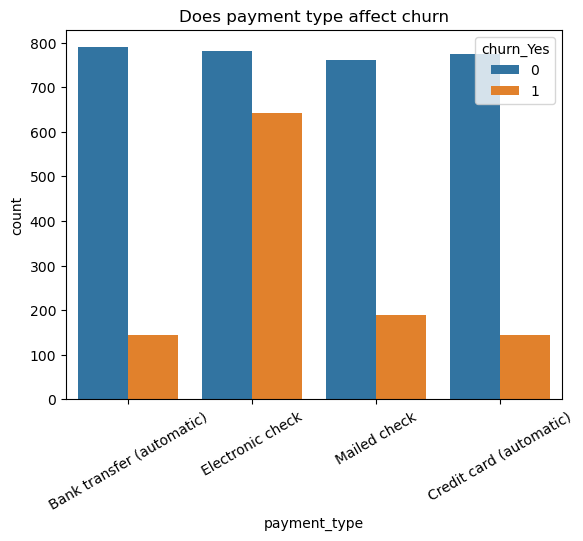

In [7]:
#plotting churn_Yes and payment type
wrangle.get_barplot_payment_type(train)

- a little above 40% of the people who churned paid by electronic check

- payment_type affects the customer churn rate
<br><br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use a chi-square test to investigate weather "payment_type" and "churn_Yes" are related.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: payment_type and churn_Yes are independent of one another</b>

<b>Ha: payment_type and churn_Yes are dependent on one another</b>

In [8]:
## running a chi2 test on the training data
wrangle.chi2_test_function(train.churn_Yes, train.payment_type, 'payment_type')

p value:  5.412195802407718e-84

We reject the null hypothesis because the p value is less than alpha

payment_type and churn_Yes are dependent on one another


## Does contract type affect churn

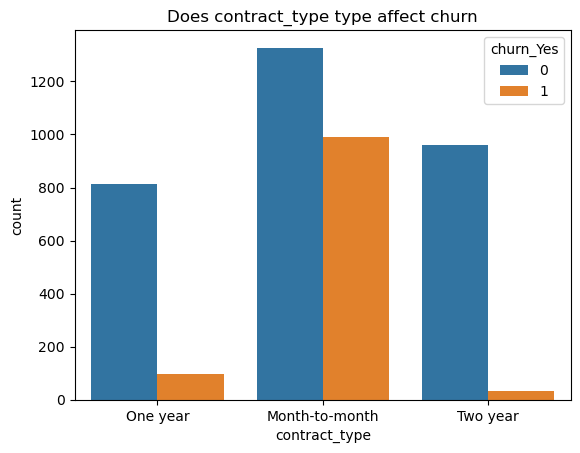

In [9]:
#plotting contract type and churn_Yes
wrangle.get_barplot_contract_type(train)

- the highest percentage of people who churned had a month to month contract
<br><br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use a chi-square test to investigate weather "contract_type" and "churn_Yes" are related.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: contract_type and churn_Yes are independent of one another</b>

<b>Ha: contract_type and churn_Yes are dependent on one another</b>

In [10]:
#running a chi2 test
wrangle.chi2_test_function(train.churn_Yes,train.contract_type, 'contract_type')

p value:  1.4947896745220748e-153

We reject the null hypothesis because the p value is less than alpha

contract_type and churn_Yes are dependent on one another


## Does device pretection affect churn

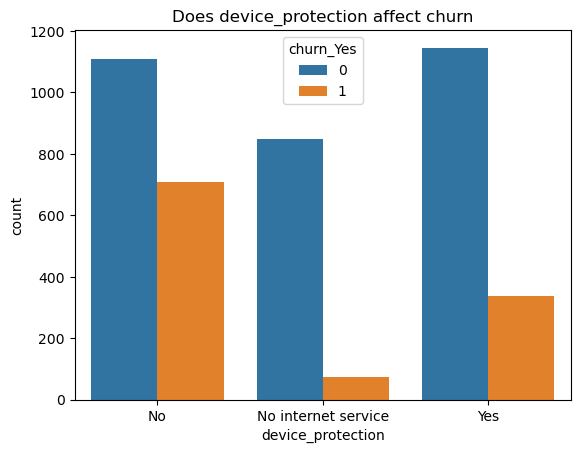

In [11]:
wrangle.get_barplot_device_protection(train)

- The highest percentage of people who have churned did not have device protection
<br><br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use a chi-square test to investigate weather "device_protection" and "churn_Yes" are related.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: device_protection and churn_Yes are independent of one another</b>

<b>Ha: device_protection and churn_Yes are dependent on one another</b>

In [12]:
## running a chi2 test
wrangle.chi2_test_function(train.churn_Yes,train.device_protection, 'device_protection')

p value:  4.9488394966464925e-70

We reject the null hypothesis because the p value is less than alpha

device_protection and churn_Yes are dependent on one another


## Does tech support type affect churn

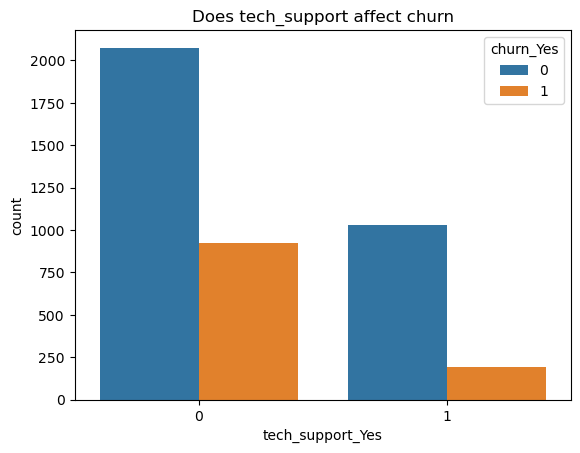

In [13]:
#plotting tech_support and churn_Yes
wrangle.get_barplot_tech_support(train)

- The highest percentage of the people who have churned did not have tech support
<br><br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use a chi-square test to investigate weather "tech_support" and "churn_Yes" are related.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: tech_support and churn_Yes are independent of one another</b>

<b>Ha: tech_support and churn_Yes are dependent on one another</b>

In [14]:
## running a chi2 test
wrangle.chi2_test_function(train.churn_Yes,train.device_protection, 'tech_support')

p value:  4.9488394966464925e-70

We reject the null hypothesis because the p value is less than alpha

tech_support and churn_Yes are dependent on one another


## Exploration Summary

- among people who have churned not having tech support and device_protection seemed to be common factors
<br>
- among people who have churned most had month to month contracts 
<br>
- among the people who have churned most of them paid by electronic check

## Features I am moving to modeling With

- contract_type 
- tech_support
- payment type
- device_protection
- reasoning (because the p value from the chi2 tests came back less than alpha meaning that they were all dependent on churn_Yes)

In [15]:
# finding the most occuring value and creating a baseline column
# figuring out the baseline
baseline = wrangle.finding_baseline(train)


Baseline 0.7346745562130178


## Modeling

- I will use my accuracy evaluation metric
- people who haven't churned makeup 73% of the data

** by guessing false customer one could achieve an accuracy of 73% <br>
** 73% will be the baseline accuracy I use for this project <br>
<br>
** I will be evaluating models developed using four different model types and various hyperparameter configurations * Models will be evaluated on train and validate data * The model that performs the best will then be evaluated on test data

In [16]:
# setting up the data that will be sent through my models
columns = ['tech_support_Yes','device_protection_Yes','contract_type_Two year','contract_type_One year','payment_type_Credit_card','payment_type_Electronic_check','payment_type_Mailed_check']

X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle.model_setup(train, test, validate, columns)

## Decision Tree

In [17]:
#creating a Decision tree model
# fitting the Descision tree model
# predicting the training and validate data

tree, train_predict, validate_predict , max_depth= wrangle.create_descision_tree(X_train, y_train, X_validate, y_validate,max_depth=6)
wrangle.print_statement_for_models(baseline ,train_predict, validate_predict)

Baseline 73.0
training data prediciton 76.0
validate data prediciton 77.0


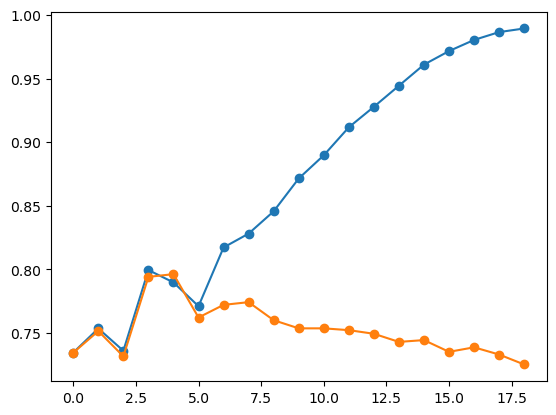

Baseline 73.0
test data prediciton 76.0


In [18]:
## uses random tree classifier model to find a range of max depths with the given columns
the_dataframe = wrangle.the_fifth_visual(train, validate, test)

#ran the random tree prediction test data
test_predict = tree.score(X_test, y_test)
print('Baseline',(train.baseline == train.churn_Yes).mean().round(2) * 100)
print('test data prediciton', test_predict.round(2) * 100)


## Random Forest

In [19]:
# creating a random forest model
# predicting the training and validate data

forest, train_predict, validate_predict ,max_depth= wrangle.create_descision_tree(X_train, y_train, X_validate, y_validate,max_depth=6)
wrangle.print_statement_for_models(baseline ,train_predict, validate_predict)

Baseline 73.0
training data prediciton 76.0
validate data prediciton 77.0


## Logistic Regression

In [20]:
# creating a Logistic Regression model
# predicting the training and validate data

logit, train_predict, validate_predict = wrangle.create_logistic_regression(X_train, y_train, X_validate, y_validate,the_c = 1)
wrangle.print_statement_for_models(baseline ,train_predict, validate_predict)

Baseline 73.0
training data prediciton 76.0
validate data prediciton 77.0


## KNN

In [21]:
# creating a KNN model
# predicting the training and validate data

knn, train_predict, validate_predict = wrangle.create_knn(X_train, y_train, X_validate, y_validate)
wrangle.print_statement_for_models(baseline ,train_predict, validate_predict)

Baseline 73.0
training data prediciton 68.0
validate data prediciton 67.0


## Modeling Summary

- DecisionTree and Random forest performed the best at 3% accuracy above the baseline
- Logistic Regression performed 2% above the baseline
- KNN performed the worst at 6% under baseline

# Conclusions

## Exploration

- A little above 40% of the people who churned paid by electronic check
- The highest percentage of people who churned had a month to month contract
- The Highest percentage of people who have churned did not have device protection
- The highest percentage of the people who have churned did not have tech support

# modeling

## Recommendations

#### Recap

- Churn was dependent on payment type 
- payment type held the highest importance in the descision making process for random tree
- the majority of people who churned paid by electronic check

### solution

- offer a 10 percent discount on the monthly bill for 3 months for enrolling in any bill payment type other than electronic check
- offer a tech support cost reduction for 3 months on 1 year contracts for enrolling in bill payment other than electronic check
- offer 2 year contract service cost reduction for enrolling in bill payment other than electronic check

## Next Steps

- look for other catagories that churn_Yes is dependent on 
- look for other catagories that affect a higher percentage of the overall customer base
- start inputing different column information for the modeling tests

## Code for making the .CSV

In [22]:
## created the CSV file and saved it
the_csv = wrangle.create_csv(tree, X_test, test)
the_csv

,customer_id,Probability_of_churn,Churn_predict
3160,4531-AUZNK,0.797297,no
1577,2296-DKZFP,0.869565,no
6823,9692-TUSXH,0.440510,yes
3615,5129-JLPIS,0.992063,no
882,1273-MTETI,0.440510,yes
...,...,...,...
1097,1597-FZREH,0.440510,yes
6441,9117-SHLZX,0.639344,no
5985,8441-SHIPE,0.911765,no
2452,3511-BFTJW,0.972973,no


## pulling the Data from the CSV

In [23]:
# pulling the CSV file to make sure it looked ok
df = pd.read_csv('Churn_Predictions.csv')
df.drop(columns = 'Unnamed: 0')

,customer_id,Probability_of_churn,Churn_predict
0,4531-AUZNK,0.797297,no
1,2296-DKZFP,0.869565,no
2,9692-TUSXH,0.440510,yes
3,5129-JLPIS,0.992063,no
4,1273-MTETI,0.440510,yes
...,...,...,...
1404,1597-FZREH,0.440510,yes
1405,9117-SHLZX,0.639344,no
1406,8441-SHIPE,0.911765,no
1407,3511-BFTJW,0.972973,no


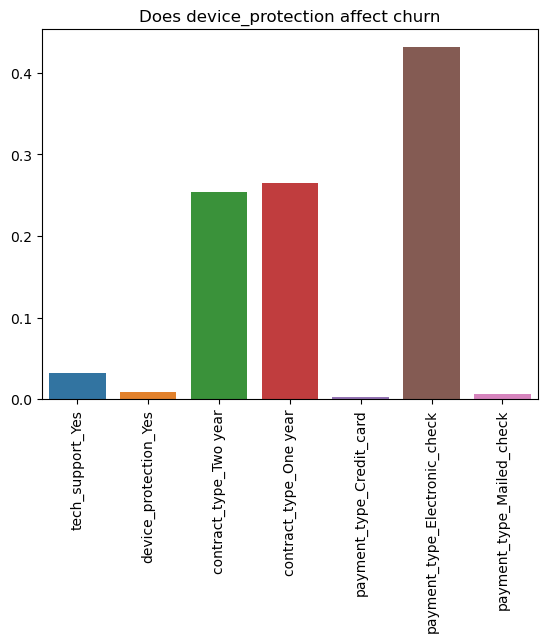

In [24]:
## looking at how much weith each column holds on my descision tree
wrangle.getting_weights(tree)

the amount of the total customers that pay by electronic check 34.0 percent


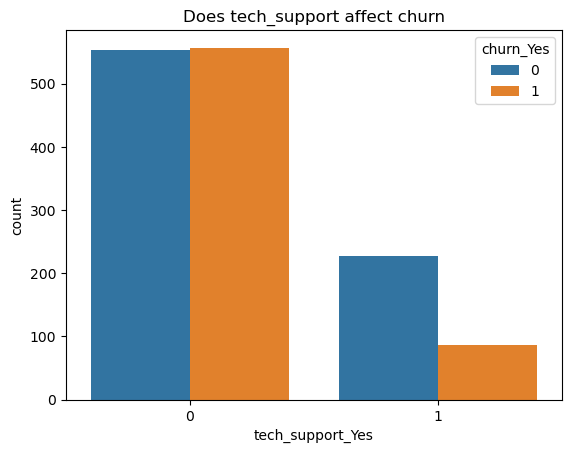

In [25]:
## 33 percent of people who in the company pay by electronic check
print('the amount of the total customers that pay by electronic check',(train.payment_type_Electronic_check == 1).mean().round(2)*100, 'percent')


##sub population payment_type_Electronic_check
the_subgroup = train[train.payment_type_Electronic_check == 1]
the_subgroup

## of the people who pay by electronic check
## most of them who churned do not have tech support
wrangle.get_barplot_tech_support(the_subgroup)

## solution for people who pay by electronic check offer incentives 
## free tech support for a certain period of time
## cheaper tech support for switching payment types

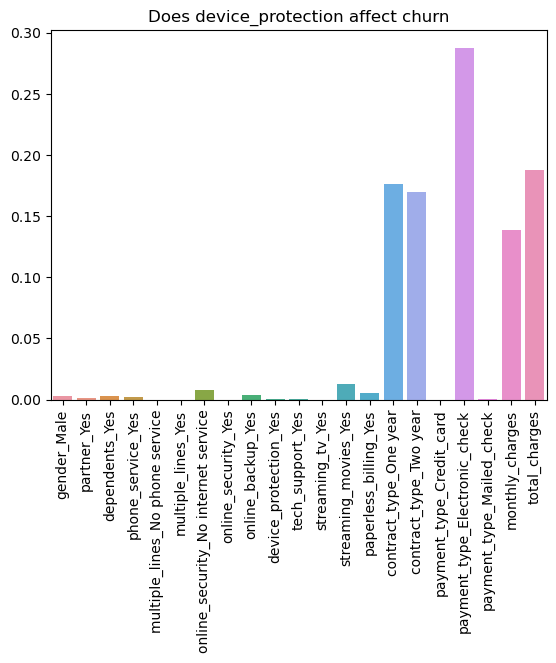

In [26]:
## figure out what holds the most weight

X_train, X_validate, X_test, y_train, y_validate, y_test, tree= wrangle.setup_for_the_extra_model_descision_tree(train, validate, test)
wrangle.getting_weights_max(tree, X_train)

In [27]:
## creating the subgroups for further analysis

columns = ['payment_type_Electronic_check', 'contract_type_Two year','contract_type_One year']

the_list = wrangle.getting_subgroup(columns, train)
payment_type_Electronic_check = the_list[0] 
contract_type_Two = the_list[1] 
contract_type_One = the_list[2] 

payment_type_Electronic_check makes up 34.0 percent of the total customer base
contract_type_Two year makes up 24.0 percent of the total customer base
contract_type_One year makes up 22.0 percent of the total customer base


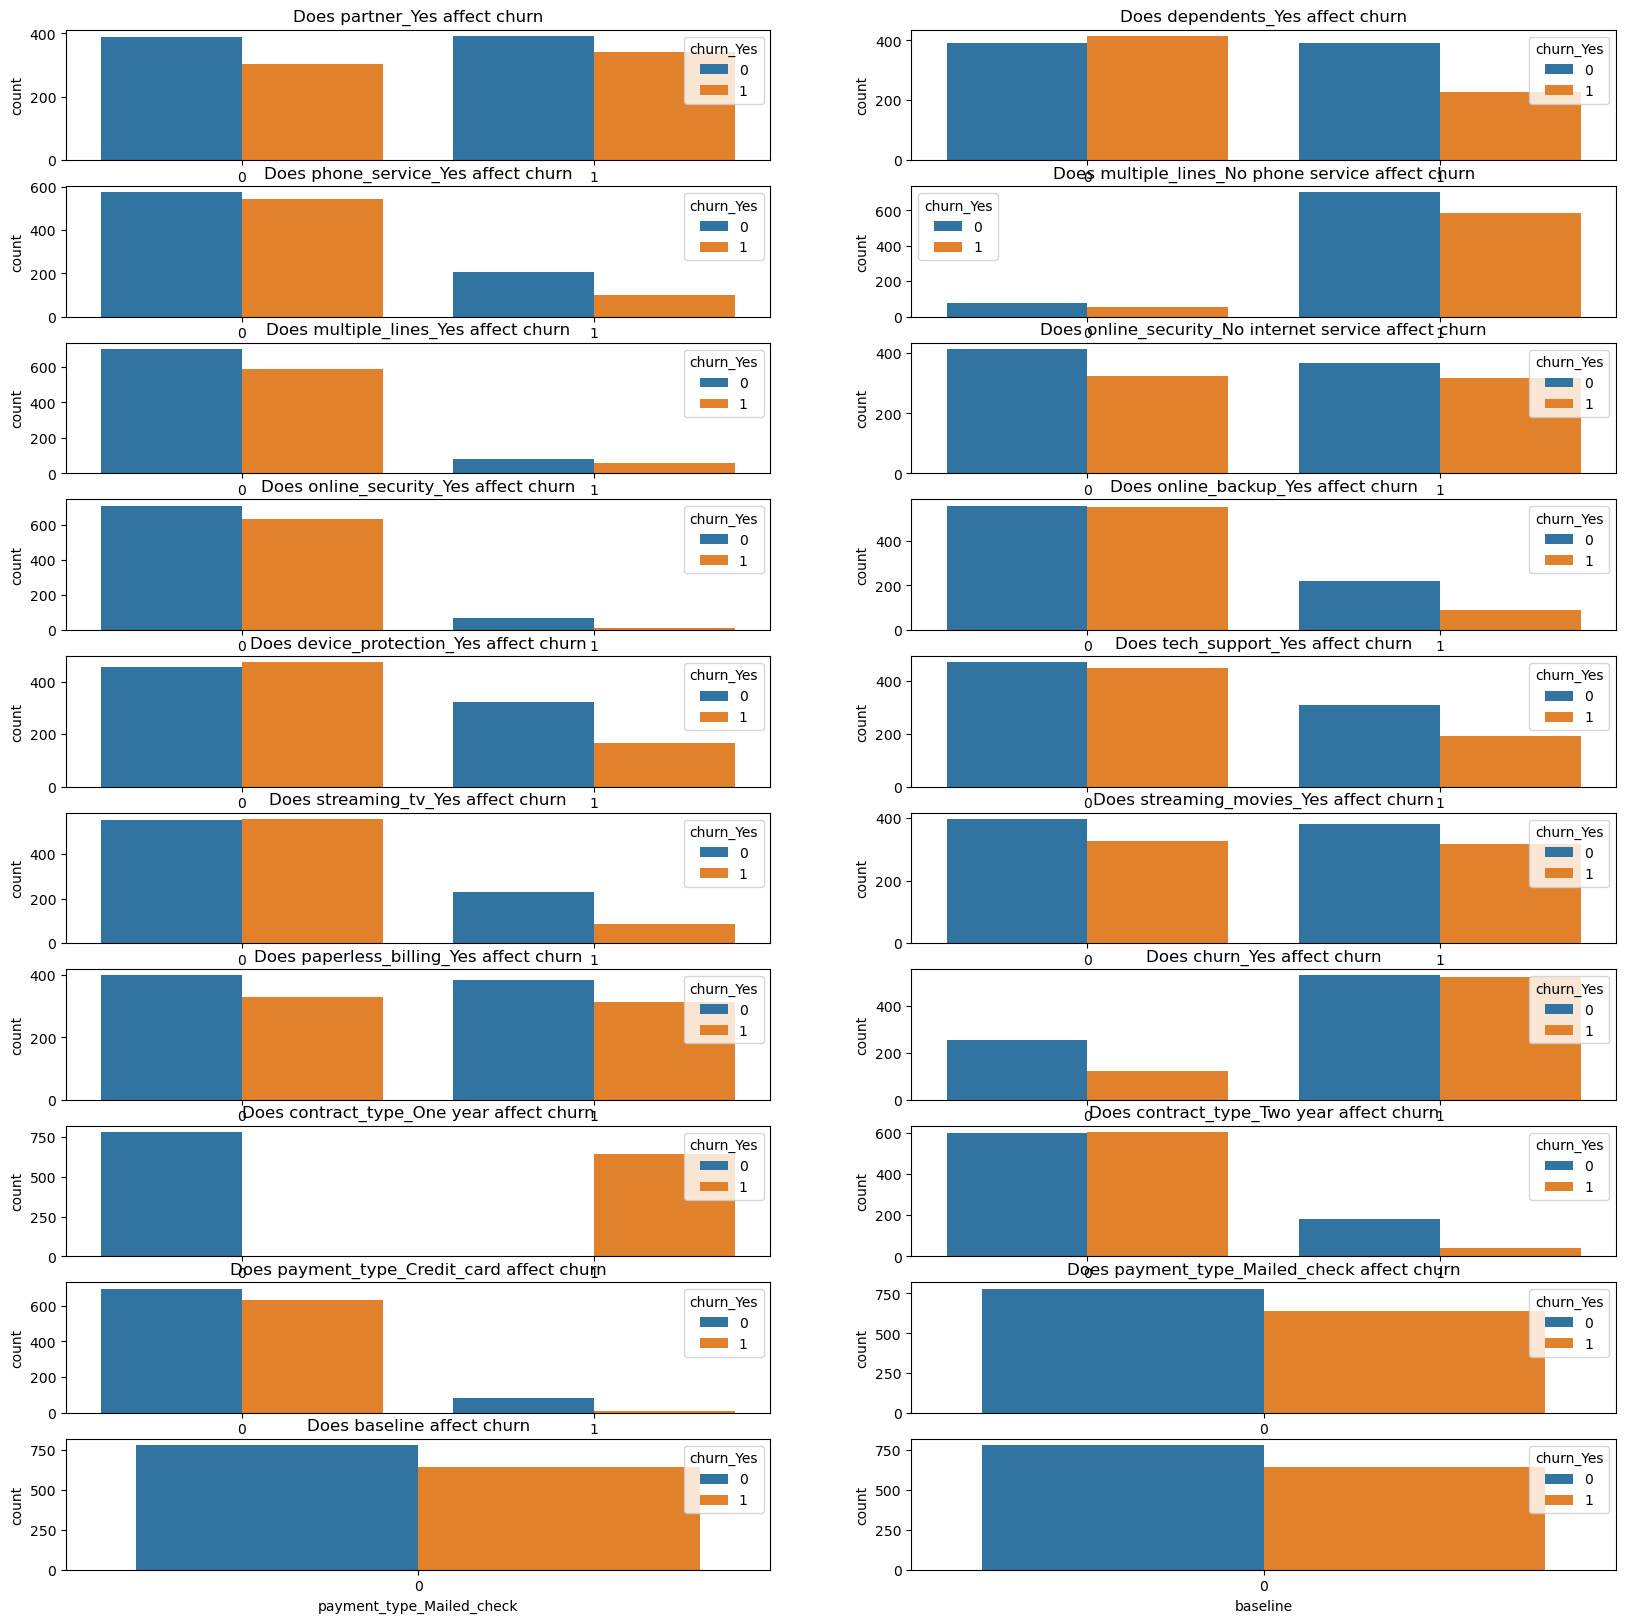

In [28]:
wrangle.get_barplot_for_everything(payment_type_Electronic_check, name='payment_type_Electronic_check')